# Contrôle optimal TP 2

Modèle SIR, stratégie optimale de confinement

In [118]:
import numpy as np
import matplotlib.pyplot as plt  
from gekko import GEKKO

## Introduction 

Considérons le modèle SIR (Susceptible-Infected-Removed) :
$$
\begin{cases}
    S'(t) = -u(t) \frac{S(t)I(t)}{N(t)} \text{  ,  } t  \geq 0 \\
    I'(t) = u(t) \frac{S(t)I(t)}{N(t)} - \beta I(t) \text{,  }  \\
    R'(t) = \beta I(t) \text{,  }\\
    (S(0),I(0),R(0)) = (S_{0},I_{0},R_{0})
\end{cases}
$$


Avec $S(t)$ le nombre de personnes saines au temps $t$, $I(t)$ le nombre de personnes infectées, $R(t)$ le nombre de personnes retirées (guéries ou décédées), et la fonction $u(·) \in L^{ \infty} (\mathbb{R}_{+})$ à valeurs dans $[0,α]$ un contrôle modélisant une politique de restriction, typiquement un confinement.

La quantité $N = S(t) + I(t) + R(t)$ représente alors la population constante totale au cours du temps. 



Nous choisissons de modéliser la recherche d’une stratégie de restriction optimale de la façon
suivante :


$$
\underset {u \in U_{a}}{\inf} L_{\tau}(u) \hspace{ 0.5 cm}
\text { avec }  U_{a} = \{ u \in L^{ \infty}(]0,T[) \text{ | } 0 \leq u(·)  \leq \alpha \} 
$$
$
où \tau \in [0,1] \text{ est fixé et } 
$
$$
L_{\tau}(u) = \tau \int_{0}^{T} g(u(t))dt + (1 - \tau ) \int_{0}^{T} f(I(t))dt.
$$

La fonction $g$ est supposée $C^{1}$, positive et décroissante sur $[0,α]$ tandis que la fonction f est supposée $C^{1}$, positive et croissante. On pourra par exemple choisir

$$
g(u) = \frac{1}{2}(\alpha^{2} - u^{2}) \text{, } \hspace{ 0.4 cm} f(u) = \frac{I^{2}}{2} \text{ ou } f(u) = I
$$

## Question 1

Justifions le choix de la fonctionnelle $L_{\tau}$

La fonctionnelle $L_{\tau}$ combine deux termes $\tau \int_{0}^{T} g(u(t))dt$ et $(1 - \tau) \int_{0}^{T} f(I(t))dt$. Le premier ,pondéré par le paramètre $\tau$, dépend de la variable de contrôle $u(t)$. La fonction $g$ est choisie de manière à être décroissante sur l'intervalle $[0, \alpha]$, de cette façon plus $u(t)$  est élevées plus le coût est plus faible.

Le deuxième terme, pondéré par $(1 - \tau)$,  dépend de la variable d'état $I(t)$. Cette composante représente le coût associé à l'évolution de la variable d'état $I(t)$. La fonction $f$, croissante, traduit l'idée que des valeurs plus élevées de $I(t)$ entraînent un coût plus élevé.

## Question 2


Vérifions que la fonction $N(·)$ est constante

On veut avoir  $\frac{d}{dt}N(t) = 0$ 

$$
\begin{align*}
\frac{d}{dt}N(t) &= \frac{d}{dt}S(t) + \frac{d}{dt}I(t) + \frac{d}{dt}R(t) \\
&= S'(t) + I'(t) + R'(t) \\
&= -u(t) \frac{S(t)I(t)}{N(t)} + u(t) \frac{S(t)I(t)}{N(t)} - \beta I(t) + \beta I(t) \\
&= 0
\end{align*}
$$

Donc $N(·)$ est constante.

## Question 3
Cas de contrôles constants

On utilise une méthode de Runge-Kutta  d’ordre 4 pour résoudre le système SIR.

In [81]:
# Paramètres de discrétisation
t0 = 0.0
T = 90 
NT = int(2e2)
tval = np.linspace(t0, T, NT)
h = (T - t0) / (NT - 1)
ITER = int(2e4)

# Paramètres du modèle
alpha, beta = 0.32, 0.1

# Conditions initiales
S0,I0,R0 = 6.7e5, 2e4 , 0

# S0,I0,R0 = 6.7e7, 2e4 , 0
N = S0 + I0 + R0


# Définition de la fonction f_primal
def f_primal(u, y):
    dy = np.array([-u * y[0] * y[1] / N,
                   u * y[0] * y[1] / N - beta * y[1],
                   beta * y[1],
                   0.5 * (alpha**2 - u**2),
                   0.5 * (y[1])**2])
    return dy

# Définition de la méthode RK4_state
def RK4_state(u):
    # Initialisation de la matrice w pour stocker les résultats
    w = np.zeros((NT, 5))
    g,f = 0.5 * (alpha**2 - u[0]**2), 0.5 * (I0)**2
    w[0, :] = S0,I0,R0,g,f  # Conditions initiales

    print(w.shape)
    for i in range(NT - 1):
        k1 = h * f_primal(u[i], w[i, :])
        k2 = h * f_primal(0.5 * (u[i] + u[i+1]), w[i, :] + 0.5 * k1)
        k3 = h * f_primal(0.5 * (u[i] + u[i+1]), w[i, :] + 0.5 * k2) 
        k4 = h * f_primal(u[i+1], w[i, :] + k3)
        w[i+1, :] = w[i, :] + (k1 + 2*k2 + 2*k3 + k4) / 6
    return w

# Affichage de la solution du problème
def plot_solution(t,S,I,R):
    t =tval
    plt.figure()
    plt.grid()
    plt.title("Runge-Kutta order 4 method")
    plt.plot(t, S, 'orange', label='Susceptible')
    plt.plot(t, I, 'r', label='Infected')
    plt.plot(t, R, 'g', label='Recovered with immunity')
    plt.xlabel('Time t, [days]')
    plt.ylabel('Numbers of individuals')
    plt.ylim([0,N])
    plt.legend()

    plt.show()


Dans chacun des deux cas suivants, représentons les solutions
S, I et R du système sur $[0,T]$ 

### Cas  $u(·) = \alpha$

(200, 5)


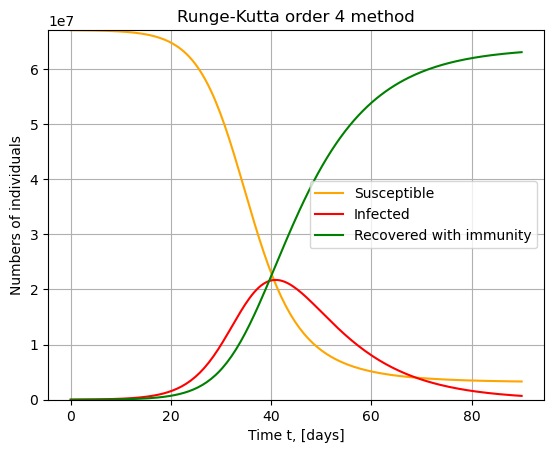

In [82]:
# pas de confinement avec u = alpha
u_init = alpha*np.ones(NT)  

# Conditions initiales
S0,I0,R0 = 6.7e7, 2e4 , 0
N = S0 + I0 + R0

# resolution du probleme SIR par Runge Kutta d'ordre 4
results = RK4_state(u_init)

# Affichons la solution
S,I,R = results[:,0],results[:,1],results[:,2]
plot_solution(tval,S,I,R)


### Cas  $u(·) = \epsilon$ 

(200, 5)


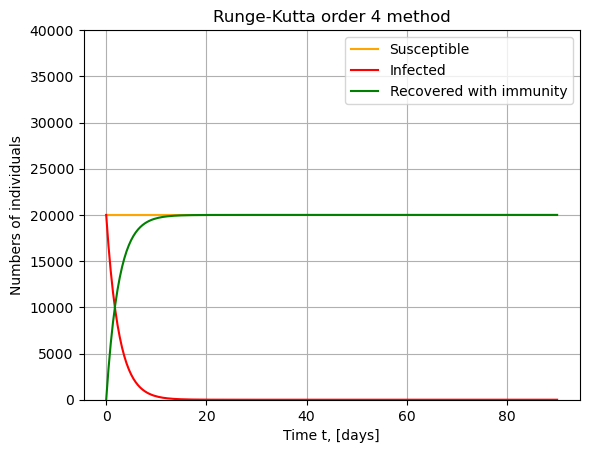

In [84]:
# confinement fort avec u = epsilon
epsilon = 0.0000001
u_init = epsilon*np.ones(NT)  

# Conditions initiales
S0,I0,R0 = 2e4, 2e4 , 0
N = S0 + I0 + R0


# resolution du probleme SIR par Runge Kutta d'ordre 4
results = RK4_state(u_init)

# Affichons la solution
S,I,R = results[:,0],results[:,1],results[:,2]
plot_solution(tval,S,I,R)

## Question 4

Calcul du gradient

Calculons la différentielle de $L_{\tau}$ :

Soit $h$ , une pertubation admissible de $u \in \mathcal{U}_{\alpha}$ , autrement dit une fonction de $L^{\infty}(]0,T[)$ telle que $u +\epsilon h \in \mathcal{U}_{\alpha} $ , si $ \epsilon > 0 $ est assez peti. On a :

$$
\begin{align*}
D L_{\tau}(u) \cdot{h} &= \underset{ \epsilon \to 0}{lim} \frac { L_{\tau}( u +\epsilon h ) - L_{\tau}( u )}{ \epsilon } \\
&= \frac{ d }{d \epsilon } L_{\tau}( u +\epsilon h ) |_{ \epsilon =  0}\\
\end{align*}
$$

Soit ($\dot{S},\dot{I},\dot{R}$) la différentielle de ($ S_{u},I_{u},R_{u} $) en $u$ dans la direction $h$ , autrement dit 
$$
\dot{S}(\cdot) = \frac { d }{ d \epsilon } S_{u +\epsilon h } (\cdot) |_{ \epsilon =  0} \\
\dot{I}(\cdot) = \frac { d }{ d \epsilon } I_{u +\epsilon h } (\cdot) |_{ \epsilon =  0} \\
\dot{R}(\cdot) = \frac { d }{ d \epsilon } R_{u +\epsilon h } (\cdot) |_{ \epsilon =  0} \\
$$

On a :
$$
D L_{\tau}(u) \cdot{h} = \frac { d }{ d \epsilon }  L_{\tau}( u +\epsilon h ) |_{ \epsilon =  0} 
= \tau \int_{0}^{T} g'(u(t)) h(t) dt + (1-\tau) \int_{0}^{T}\dot{I}(t) f'(\dot{I}(t)) dt  \\
$$


Déterminons  $(\dot{S},\dot{I},\dot{R})$

On a pour tout $t \geq 0 $:
$$
S'_{u +\epsilon h }(t) = -(u(t) +\epsilon h(t)) \frac{S_{u +\epsilon h}(t) I_{u +\epsilon h } (t) }{N}
$$
Dérivons cette relation par raport à $\epsilon$ ( on rappelle que $N$ est constant) et évaluons l'égalité obtenue en $\epsilon = 0$.
On trouve :
$$
S'_{u +\epsilon h }(t) = -h(t)\frac{S_{u}(t) I_{u}(t) }{N}  -u(t)\frac{\dot{S}(t) I_{u}(t) }{N} -u(t)\frac{ S_{u}(t) \dot{I}(t) }{N}
$$
De la même façon,
$$
I'_{u +\epsilon h }(t) = h(t)\frac{S_{u}(t) I_{u}(t) }{N}  + u(t)\frac{\dot{S}(t) I_{u}(t) }{N} + u(t)\frac{ S_{u}(t) \dot{I}(t) }{N}- \beta \dot{I}(t)
$$
et 
$I'_{u +\epsilon h }(t) =  \beta \dot{I}(t) \text{ et de plus } (\dot{S}(0),\dot{I}(0),\dot{R}(0)) = (0,0,0) $

Calculons le gradient de $L_{\tau}$ en $u$ :

En miltipliant au sens du produit scalaire les équations sur $(\dot{S},\dot{I},\dot{R})$ par ($ P_{1},P_{2},P_{3}$), on trouve :


$
\int_{0}^{T}\dot{S}'(t)P_{1}(t) dt + \int_{0}^{T}\dot{I}'(t)P_{2}(t) dt + \int_{0}^{T}\dot{R}'(t)P_{3}(t) dt = \\
\int_{0}^{T} [-h \frac{SI}{N}P_{1} -u \frac{\dot{S}I}{N}P_{1} -u \frac{S\dot{I}}{N}P_{1} - h \frac{SI}{N}P_{2} -u \frac{\dot{S}I}{N}P_{2} -u \frac{S\dot{I}}{N}P_{2}- \beta \dot{I}P_{2} + \beta \dot{I}P_{3}  ] dt
$

et après l'intégration par partie, il vient : 
$$
\int_{0}^{T} (-P'_{1}\dot{S} - P'_{2}\dot{I} - P'_{3} \dot{R}) dt + [ \dot{S}P_{1} + \dot{I}P_{2} + \dot{R} P_{3} ]^{T}_{0}
$$
Comme $(\dot{S},\dot{I},\dot{R})(0) = (0,0,0)$ par $(P_{1},P_{2},P_{3}) = (0,0,0)$ alors 

$$
\int_{0}^{T} (-P'_{1}\dot{S} - P'_{2}\dot{I} - P'_{3} \dot{R}) dt = 
\int_{0}^{T} h[ \frac{SI}{N}P_{2} - \frac{SI}{N}P_{1}] +  
\begin{pmatrix}
\frac{-uI}{N} & \frac{-uS}{N} & 0  \\
\frac{uI}{N} & \frac{uS}{N} & -\beta  \\
0 & \beta & 0  \\
\end{pmatrix}
\begin{pmatrix}
\dot{S} \\
\dot{I} \\
\dot{R}\\
\end{pmatrix}
\cdot{}
\begin{pmatrix}
P_{1}\\
P_{2}\\
P_{3}\\
\end{pmatrix}
dt
$$

$$
\text{ Notons }
A = \begin{pmatrix}
\frac{-uI}{N} & \frac{-uS}{N} & 0  \\
\frac{uI}{N} & \frac{uS}{N} & -\beta  \\
0 & \beta & 0  \\
\end{pmatrix}
\text{ alors }
A
\begin{pmatrix}
\dot{S} \\
\dot{I} \\
\dot{R}\\
\end{pmatrix}
\cdot{}
\begin{pmatrix}
P_{1}\\
P_{2}\\
P_{3}\\
\end{pmatrix}
=
\begin{pmatrix}
\dot{S} \\
\dot{I} \\
\dot{R}\\
\end{pmatrix}
\cdot{}
A^{T}
\begin{pmatrix}
P_{1}\\
P_{2}\\
P_{3}\\
\end{pmatrix}
$$

et finalement 

$$
\int_{0}^{T}
\begin{pmatrix}
\dot{S} \\
\dot{I} \\
\dot{R}\\
\end{pmatrix}
\cdot{}

(-\begin{pmatrix}
P'_{1}\\
P'_{2}\\
P'_{3}\\
\end{pmatrix}
-A^{T}
\begin{pmatrix}
P_{1}\\
P_{2}\\
P_{3}\\
\end{pmatrix})dt
= \int_{0}^{T}
h\frac{SI}{N} [P_{2} - P_{1}] dt
$$


Utilisons l'équation sur l'adjoint $\begin{pmatrix}
P_{1}\\
P_{2}\\
P_{3}\\
\end{pmatrix}$ , on obtient finalement :

$$
\int_{0}^{T}
\begin{pmatrix}
\dot{S} \\
\dot{I} \\
\dot{R}\\
\end{pmatrix}
\cdot{}
\begin{pmatrix}
0 \\
f'(I)\\
0 \\
\end{pmatrix}dt
= \int_{0}^{T}
h\frac{SI}{N} [P_{2} - P_{1}] dt
$$
Ainsi 

$$
\int_{0}^{T}
\dot{I} 
f'(I)
= \int_{0}^{T}
h\frac{SI}{N} [P_{2} - P_{1}] dt
\quad \text{ et par conséquent, }
$$

$$
\begin{align*}
D L_{\tau}(u) \cdot{h} &= \tau \int_{0}^{T} g'(u(t)) h(t) dt + (1 - \tau) \int_{0}^{T} \dot{I}(t) f'(I(t)) dt \\
&= \tau \int_{0}^{T} g'(u(t)) h(t) dt + (1 - \tau) \int_{0}^{T} \frac{h(t)S(t)I(t)}{N} (P_{2}(t) - P_{1}(t)) dt \\
&= \int_{0}^{T} h(t) \psi(t)  dt =  \langle h, \psi \rangle_{L^{2}(]0,T[)}
\end{align*}
$$
avec $\psi (t) =  \tau g'(u(t)) + (1 - \tau) \frac{S(t)I(t)}{N} (P_{2}(t) - P_{1}(t)) \text{ et } \psi \text{ est le gradient de la fonctionnelle } L_{\tau}$

$$
\nabla L_{\tau}(t) = \psi(t) \text{ p.p. } t \in [0,T]
$$

## Question 5
Mise en œuvre d’une méthode de gradient

In [85]:
# Définir les fonctions g(u), g'(u) et f(I),f'(I)
def g(u):
    return (alpha**2 - u**2)/2
def gprime(u):
    return -u  
def f(I):
    return I # (I**2)/2 
def fprime(I):
    return np.ones(shape = np.shape(I)) # I

# Définition de la fonction f_primal
def f_primal(u, x):
    dx_dt = np.array([-u * x[0] * x[1] / N,
                   u * x[0] * x[1] / N - beta * x[1],
                   beta * x[1],
                   0.5 * (alpha**2 - u**2),
                   0.5 * (x[1])**2])
    return dx_dt

# Définition de la méthode RK4_state
def RK4_state(u,x):

    # print(x.shape)
    for i in range(NT - 1):
        k1 = h * f_primal(u[i], x[i, :])
        k2 = h * f_primal(0.5 * (u[i] + u[i+1]), x[i, :] + 0.5 * k1)
        k3 = h * f_primal(0.5 * (u[i] + u[i+1]), x[i, :] + 0.5 * k2) 
        k4 = h * f_primal(u[i+1], x[i, :] + k3)
        x[i+1, :] = x[i, :] + (k1 + 2*k2 + 2*k3 + k4) / 6
    return x


# Définition de la fonction f_dual
def f_dual(u,x,p): # x = (S,I,R,g,f) ;  p = (p1,p2,p3) ; 


    A = np.array([[ -u*x[1]/N, -u*x[0]/N, 0],
                 [ u*x[1]/N, u*x[0]/N - beta, 0],
                 [ 0, beta, 0]])
    
    A_T = np.transpose(A)
    P = np.array([p[0],p[1],p[2]])
    A_TP = A_T@P
    
    fprime = 1 # x[1] # f'(I) = 1 ou I
    dP_dt = np.array([A_TP[0],A_TP[0] + fprime ,A_TP[0]])

    return dP_dt

# Définition de la méthode RK4_state_dual pour le dual
def RK4_dual(u,x,p):

    # print(p.shape)
    for i in range(NT - 1, 0, -1): # on commence par la fin du temps
    # for i in range(NT - 1, -1, -1): # on commence par la fin du temps
        k1 = h * f_dual(u[i], x[i], p[i, :])
        k2 = h * f_dual(0.5 * (u[i] + u[i-1]), x[i], p[i, :] + 0.5 * k1)
        k3 = h * f_dual(0.5 * (u[i] + u[i-1]), x[i], p[i, :] + 0.5 * k2) 
        k4 = h * f_dual(u[i-1], x[i], p[i, :] + k3)
        p[i-1, :] = p[i, :] + (k1 + 2*k2 + 2*k3 + k4) / 6
    return p


In [86]:
# Définition de la fonction L(u)
def L(tau,u_values,I_values,dt):
    # Intégration numérique (méthode des trapèzes)
    integral_g = np.trapz(g(u_values), dx=dt)
    integral_f = np.trapz(f(I_values), dx=dt)

    # Calcul final
    result = tau * integral_g + (1 - tau) * integral_f
    
    return result

# calcul du gradient de L(u)
def gradientL(tau,u_values,x,p): 
    S = x[:,0] # S(t) pour tout t 
    I = x[:,1]

    dg_du = gprime(u_values)  
    result = tau*dg_du + (1-tau)*( (S@np.transpose(I))/N) *(p[:,1] -p[:,0])
    return result


# calcul du pas pk
def optimalPas(tau,u_values,x,p,h) :
    cpt = 0
    Pas = 0  # (un nombre positif fixé)
    I_values = x[:,1]
    dL_du = gradientL(tau,u_values,x,p)
    # print("u_values -Pas*dL_du,I_values", u_values -Pas*dL_du,I_values)
    delta = L(tau,u_values -Pas*dL_du,I_values,h) - L(tau,u_values,I_values ,h)
    while ( cpt < 1e2) & (delta >= 0) :
        Pas = Pas /1.3
        delta = L(tau,u_values -Pas*dL_du,I_values, h) - L(tau,u_values,I_values, h)
        cpt = cpt + 1
    return Pas

# calcul de up1 en utilisant la formule de projection
def compute_up1(tau,Pas,u_values,x,p):
    dL_du = gradientL(tau,u_values,x,p)
    maximum = max(np.max(u_values -Pas*dL_du, axis=0),0)
    Zeros = np.zeros(shape= np.shape(u_values)) 
    up1 = np.minimum(alpha*np.ones(shape= np.shape(u_values)) ,np.maximum(u_values -Pas*dL_du,Zeros))
    return up1


# Méthode de descente de gradient
def solveSIR(tau,u_init):

    u_values = u_init 
    ####### Initialisation de la matrice x pour stocker les etats et g,f
    x = np.zeros((NT, 5))
    g_values,f_values = 0.5 * (alpha**2 - u_values[0]**2), 0.5 * x[0, 1]**2
    x[0, :] = S0,I0,R0,g_values,f_values  # Conditions initiales

    ####### Initialisation de la matrice p pour stocker l'adjoint
    p = np.zeros((NT, 3))

    ####### paramètres d'arret
    MaxIteration, epsilonTol = 1e3, 1e-3
    it, Critarret = 0,0

    it = 0
    while ( it < MaxIteration) and (Critarret <= epsilonTol) :
    ######### resoudre l'équation état x(t) 
        S_values ,I_values ,R_values  = x[:,0],x[:,1],x[:,2]

        # resolution du probleme SIR par Runge Kutta d'ordre 4
        xp1 = RK4_state(u_values,x)
        S_values_p1 ,I_values_p1 ,R_values_p1  = xp1[:,0],xp1[:,1],xp1[:,2]

    ######### resoudre l'équation adjoint p(t) 
        # resolution du probleme adjoint par Runge Kutta d'ordre 4
        pp1 = RK4_dual(u_values,xp1,p)
        P1_values_p1 ,P2_values_p1 ,P3_values_p1  = pp1[:,0],pp1[:,1],pp1[:,2]

    ######### calcul du pas 
        Pas = optimalPas(tau,u_values,xp1,pp1,h) 

    ######### calcul du u_values_p1
        u_values_p1 = compute_up1(tau,Pas,u_values,x,p)

    ######### un critère d’arrêt
        Critarret  = (L(tau,u_values_p1,I_values_p1 ,h) - L(tau,u_values,I_values ,h))/ L(tau,u_values,I_values ,h)

    ######## mise à jour de  u, x, p et de it 
        u_values = u_values_p1
        x = xp1
        p = pp1
        it= it+1
        
    return u_values_p1 , S_values_p1 ,I_values_p1 ,R_values_p1 




## Question 6

In [87]:
def Test (tau_values,u_init):
    # Création de la matrice de sous-graphiques 2x3
    fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12, 8))
    fig.suptitle("Runge-Kutta Order 4 Method", fontsize=16)

    # Boucle sur les valeurs de tau
    tau_values = [0.1, 0.5, 0.9]
    for i, tau in enumerate(tau_values):
        # Résoudre le système SIR avec la stratégie optimale
        u, S, I, R = solveSIR(tau, u_init)

        # Afficher la solution dans le sous-graphique correspondant
        ax[0, i].plot(tval, S, label='Susceptible', color='orange')
        ax[0, i].plot(tval, I, label='Infected', color='red')
        ax[0, i].plot(tval, R, label='Recovered with immunity', color='green')
        ax[1, i].plot(tval, u, label='Control')
        ax[0, i].set_title(f'Solution optimale pour tau={tau}')

    # Ajustements des paramètres globaux des sous-graphiques
    for a in ax.flat:
        a.set(xlabel='Time t, [days]', ylabel='Numbers of individuals')
        a.legend()
        a.grid(True)

    # Ajustement de l'espacement entre les sous-graphiques
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


In [88]:
# Paramètres de discrétisation
t0 = 0.0
T = 90 
NT = int(2e2)
tval = np.linspace(t0, T, NT)
h = (T - t0) / (NT - 1)
ITER = int(2e4)

# Paramètres du modèle
alpha, beta = 0.32, 0.1

# Conditions initiales de x
S0,I0,R0 = 2e4, 2e4 , 0
N = S0 + I0 + R0


### Pas de confinement 

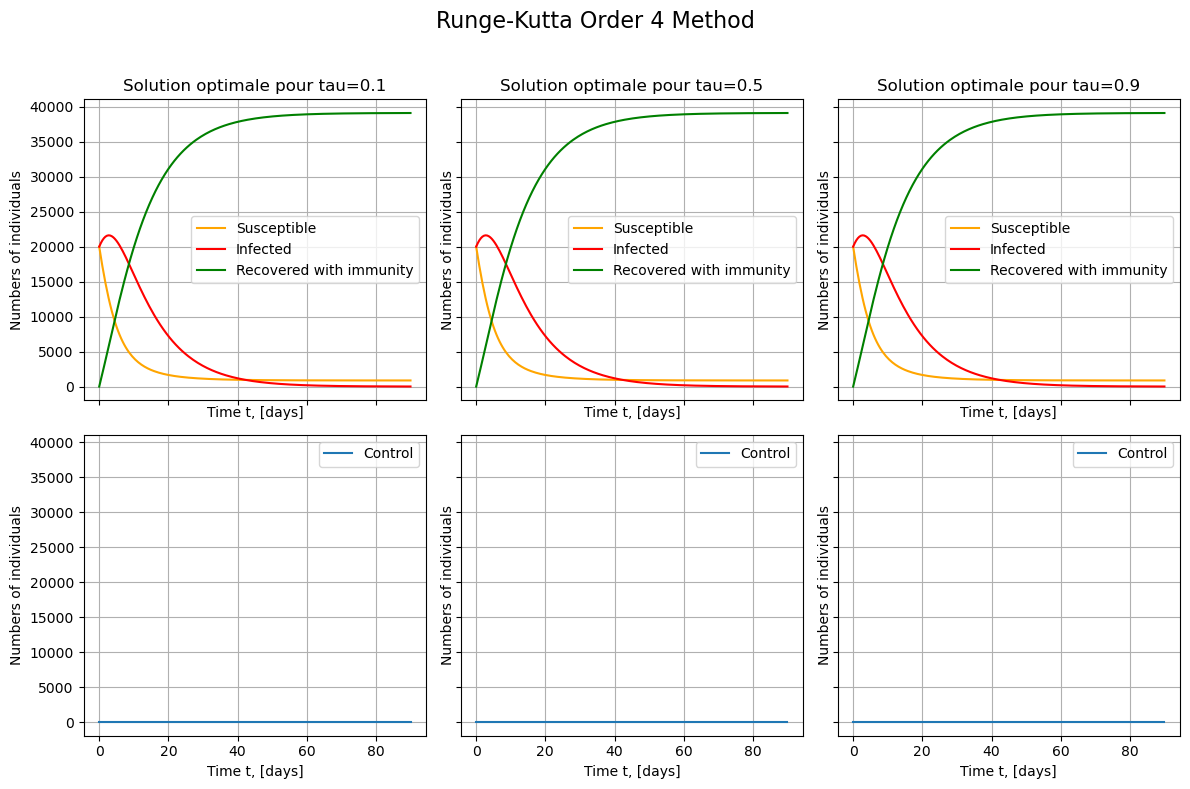

In [89]:
# Boucle sur les valeurs de tau
tau_values = [0.1, 0.5, 0.9]

# pas de confinement avec u = alpha
u_init = alpha*np.ones(NT)  

Test (tau_values,u_init)

### Confinement moyen

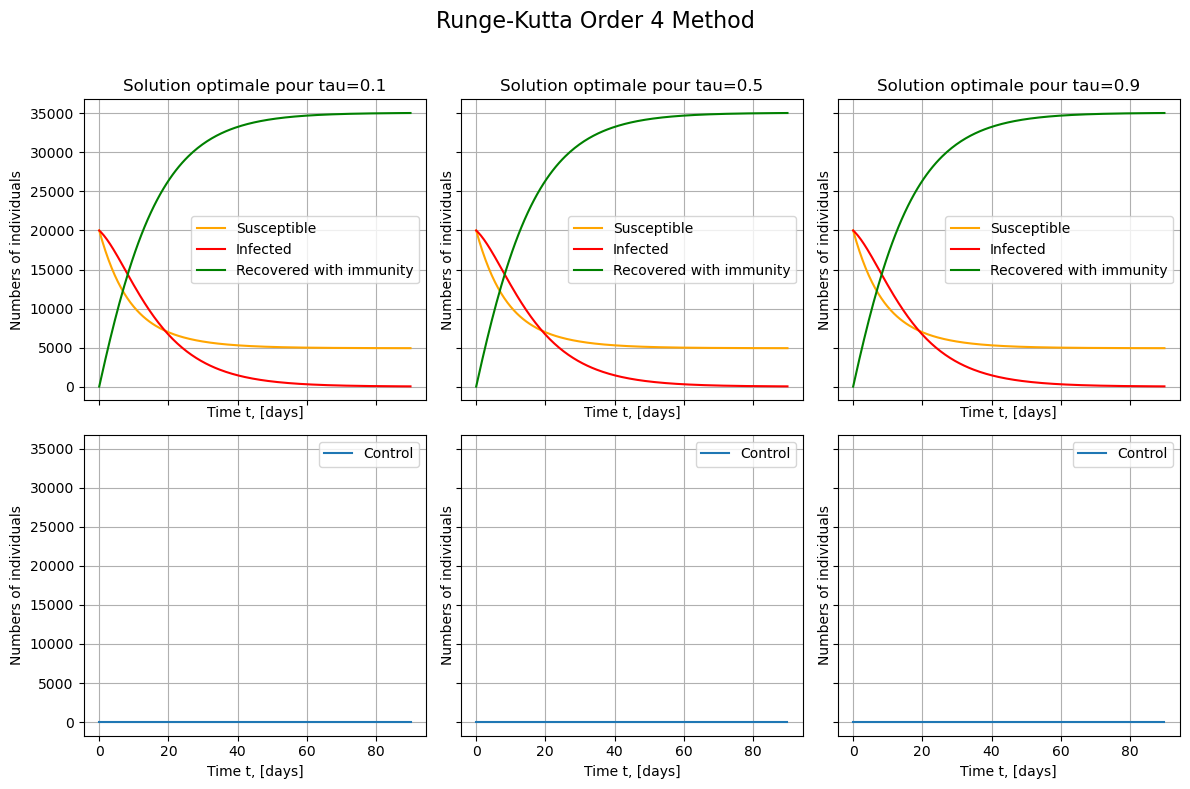

In [90]:
# Boucle sur les valeurs de tau
tau_values = [0.1, 0.5, 0.9]

# confinement moyen avec u = alpha/2
u_init = (alpha/2)*np.ones(NT)  

Test (tau_values,u_init)

### Confinement presque total

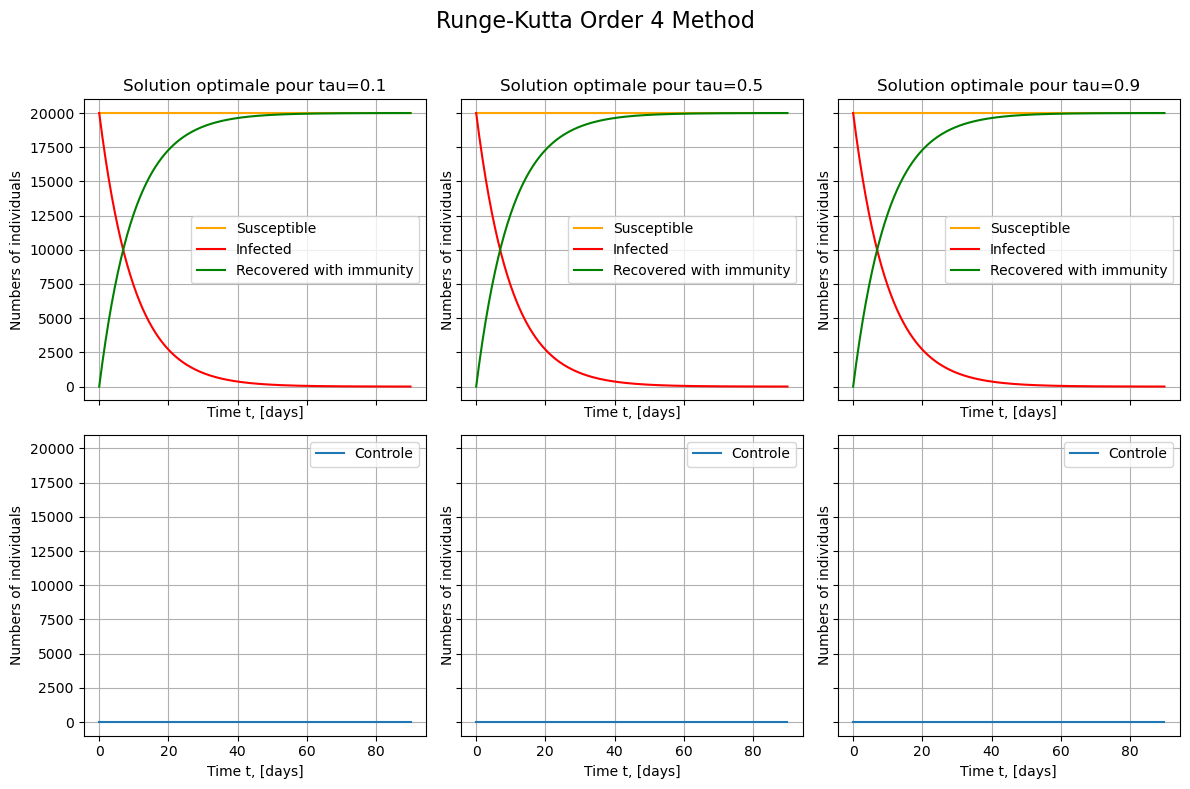

In [66]:
# Boucle sur les valeurs de tau
tau_values = [0.1, 0.5, 0.9]

# confinement fort avec u = epsilon
epsilon = 0.0000001
u_init = epsilon*np.ones(NT)  

Test (tau_values,u_init)

## Question 7

### a)

Représentons sur une figure les points
$\left(\int_{0}^{T} g(u^*\tau(t)) \, dt, \int_{0}^{T} f(I^*\tau(t)) \, dt\right)$ pour différentes valeurs de $\tau \in [0,1]$ (diagramme de Pareto).


In [96]:
# Définir la fonction pour calculer l'intégrale numérique
def calculate_integral(y, dt):
    return np.trapz(y, dx=dt)

def pareto(tau_values,u_init):
    # Initialiser les listes pour stocker les résultats
    g_integral_values = []
    f_integral_values = []

    # Boucle sur les valeurs de tau
    for tau in tau_values:
        # Résoudre le système SIR avec la stratégie optimale (à adapter selon votre modèle)
        u, S, I, R = solveSIR(tau, u_init)

        # Calculer les intégrales
        g_integral = calculate_integral(g(u), h)
        f_integral = calculate_integral(f(I), h)

        # Ajouter les résultats aux listes
        g_integral_values.append(g_integral)
        f_integral_values.append(f_integral)
        
    return g_integral_values, f_integral_values



def Plotpareto(g_integral_values,f_integral_values):
    # Afficher le diagramme de Pareto
    plt.figure(figsize=(8, 6))
    plt.plot(g_integral_values, f_integral_values, marker='o', linestyle='-', color='b')
    plt.title('Diagramme de Pareto')
    plt.xlabel(r'$\int_{0}^{T} g(u^*_{\tau}(t)) dt$')
    plt.ylabel(r'$\int_{0}^{T} f(I^*_{\tau}(t)) dt$')
    plt.grid(True)
    plt.show()


#### Diagramme de Pareto sans  confinement 

In [97]:
# Boucle sur les valeurs de tau
tau_values = [0.1, 0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# confinement moyen avec u = alpha/2
u_init = alpha*np.ones(NT)  

g_integral_values, f_integral_values = pareto(tau_values,u_init)


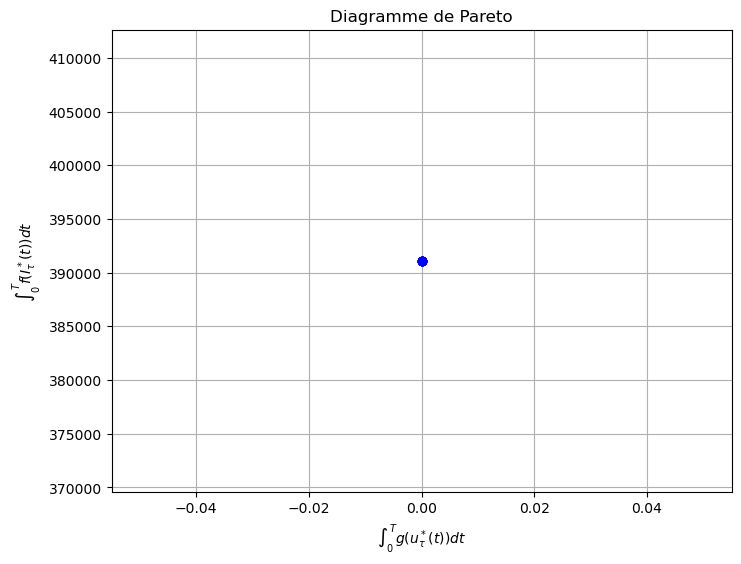

In [98]:
Plotpareto(g_integral_values,f_integral_values)

#### Diagramme de Pareto d'un confinement moyen

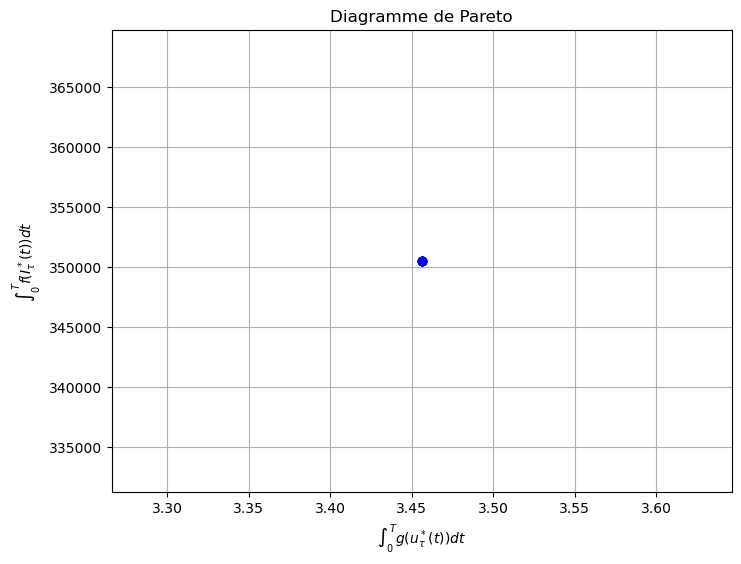

In [94]:
# Boucle sur les valeurs de tau
tau_values = [0.1, 0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# confinement moyen avec u = alpha/2
u_init = (alpha/2)*np.ones(NT)  

g_integral_values, f_integral_values = pareto(tau_values,u_init)

In [ ]:
Plotpareto(g_integral_values,f_integral_values)

#### Diagramme de Pareto d'un confinement fort

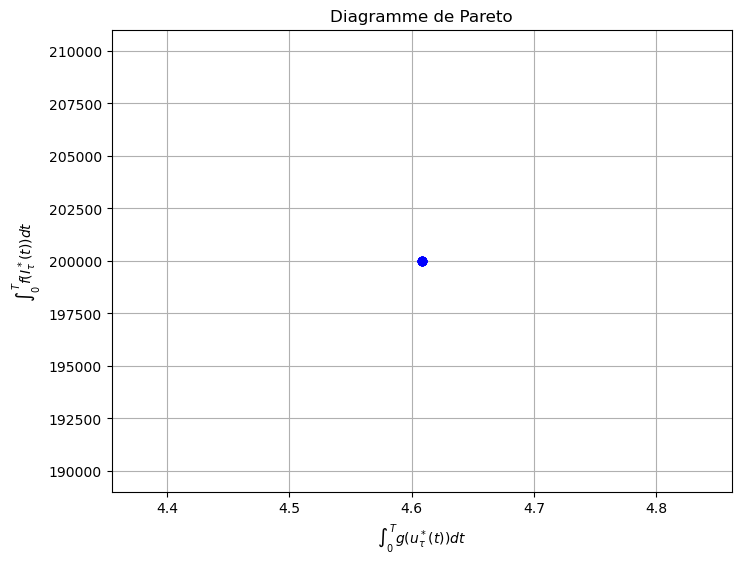

In [95]:
# Boucle sur les valeurs de tau
tau_values = [0.1, 0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# confinement fort avec u = epsilon
epsilon = 0.0000001
u_init = epsilon*np.ones(NT) 

g_integral_values, f_integral_values = pareto(tau_values,u_init)

In [ ]:
Plotpareto(g_integral_values,f_integral_values)

### b)

Implémentons le problème en utilisant le package Gekko et comparer les résultats obtenus.

In [110]:

def solveGekko(tau,u_init) :
    # Initialiser le modèle
    m = GEKKO()

    # Paramètres de discrétisation
    t0 = 0.0
    T = 90 
    NT = int(2e2)
    m.time = np.linspace(t0, T, NT)

    # mark final time point
    p = np.zeros(NT)
    p[-1] = 1.0
    final = m.Param(value=p)

    # Variables de contrôle
    u = m.MV(value= u_init,lb=0, ub=alpha)  # Contrôle u(t)
    u.STATUS = 1  # Activer l'optimisation de cette variable

    # Variables d'état
    S = m.Var(value=S0) # Condition initiale S(0) = S0 
    I = m.Var(value=I0) # Condition initiale I(0) = I0
    R = m.Var(value=R0) # Condition initiale R(0) = R0

    z = m.Var(value=0) #  Condition initiale pour l'intégrale



    # Équations différentielles
    m.Equation(S.dt() == -u* S * I / N)
    m.Equation(I.dt() == u * S * I / N - beta * I)
    m.Equation(R.dt() == beta * I)


    # Équations 
    m.Equation(z.dt() == tau*g(u) + (1-tau)*f(I))  # z˙(t) = tau*g(u) + (1-tau)*f(I)


    # Fonction objectif : minimiser  l'intégrale L

    m.Obj(z*final)


    # Résoudre le problème d'optimisation
    m.options.IMODE = 6 # optimal control mode
    m.solve(disp=False)

    return m.time,S.value,I.value,R.value,u.value


def PlotGekko(m,S,I,R,u):
    # Afficher les résultats
    plt.figure(1) 
    plt.grid()
    plt.title("Runge-Kutta order 4 method")
    plt.plot(m,S,'orange',label='Susceptible')
    plt.plot(m,I,'r-',label='Infected')
    plt.plot(m,R,'g-',label='Recovered with immunity')
    plt.plot(m,u,'k--',label=r'$u$')
    plt.xlabel('Time t, [days]')
    plt.ylabel('Numbers of individuals')
    plt.ylim([0,N])
    plt.legend()

    plt.show()

In [117]:

# Paramètres de discrétisation
t0 = 0.0
T = 90 
NT = int(2e2)
tval = np.linspace(t0, T, NT)
h = (T - t0) / (NT - 1)
ITER = int(2e4)

# Paramètres du modèle
alpha, beta = 0.32, 0.1
tau = 0.5

# Conditions initiales de x
S0,I0,R0 = 2e4, 2e4 , 0
N = S0 + I0 + R0

# confinement fort avec u = epsilon
epsilon = 0.0000001
u_init = epsilon*np.ones(NT)  


m,S,I,R,u = solveGekko(tau,u_init)
PlotGekko(m,S,I,R,u)

Exception:  @error: Solution Not Found


In [114]:
# Paramètres de discrétisation
t0 = 0.0
T = 90 
NT = int(2e2)
tval = np.linspace(t0, T, NT)
h = (T - t0) / (NT - 1)
ITER = int(2e4)

# Paramètres du modèle
alpha, beta = 0.32, 0.1
tau = 0.5

# Conditions initiales de x
S0,I0,R0 = 2e4, 2e4 , 0
N = S0 + I0 + R0

# pas de confinement avec u = alpha
u_init = alpha*np.ones(NT)  


m,S,I,R,u = solveGekko(tau,u_init)
PlotGekko(m,S,I,R,u)

Exception:  @error: Solution Not Found


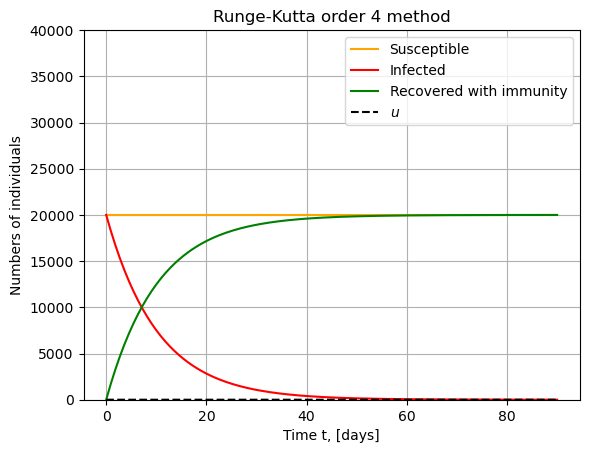

In [113]:
# Paramètres de discrétisation
t0 = 0.0
T = 90 
NT = int(2e2)
tval = np.linspace(t0, T, NT)
h = (T - t0) / (NT - 1)
ITER = int(2e4)

# Paramètres du modèle
alpha, beta = 0.32, 0.1
tau = 0.5

# Conditions initiales de x
S0,I0,R0 = 2e4, 2e4 , 0
N = S0 + I0 + R0

# confinement moyen avec u = alpha/2
u_init = (alpha/2)*np.ones(NT)  

m,S,I,R,u = solveGekko(tau,u_init)
PlotGekko(m,S,I,R,u)


### c)

Pour enrichir le modèle SIR, on pourrait rajouter une classe D pour les individus décédés. On passe alors du modèle SIR au modèle SIRD.
$$
\begin{align*}
\frac{dS}{dt} &= -\beta \cdot \frac{SI}{N} \\
\frac{dI}{dt} &= \beta \cdot \frac{SI}{N} - \gamma \cdot I - \delta \cdot I \\
\frac{dR}{dt} &= \gamma \cdot I \\
\frac{dD}{dt} &= \delta \cdot I
\end{align*}
$$

Avec $\delta$ le taux de décès des individus infectés.
